# Используемые библиотеки

In [1]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor

#https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

1) Выгрузка данных
2) Работа с данными
3) Обучение и тренировка
4) Обучение финальной модели

# Функции, используемые в коде

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [12]:
!cd 

C:\Users\Ђ«ҐЄбҐ©


# Загрузка данных

In [50]:
df = pd.read_csv('train_data.csv')
df.head(10)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,9797,-121.92,36.57,42.0,3944.0,738.0,1374.0,598.0,4.1740,NEAR OCEAN,394400.0
1,20618,-121.55,39.06,25.0,1332.0,247.0,726.0,226.0,2.2500,INLAND,63400.0
2,19139,-122.71,38.33,13.0,4011.0,936.0,2064.0,914.0,3.6953,<1H OCEAN,157600.0
3,6996,-118.03,33.95,34.0,1882.0,428.0,1034.0,375.0,3.6509,<1H OCEAN,173200.0
4,840,-122.06,37.60,18.0,1726.0,276.0,1186.0,310.0,5.3226,NEAR BAY,231700.0
5,8840,-118.38,34.08,48.0,1226.0,288.0,370.0,264.0,3.9375,<1H OCEAN,450000.0
6,12793,-121.45,38.64,NaN,1481.0,343.0,1079.0,315.0,1.8670,INLAND,60600.0
7,4571,-118.27,34.07,34.0,786.0,341.0,1239.0,320.0,2.3438,<1H OCEAN,152100.0
8,11510,-118.10,33.74,31.0,1310.0,342.0,563.0,310.0,4.6528,NEAR OCEAN,457100.0
9,3094,-118.45,35.58,NaN,5396.0,1182.0,1802.0,807.0,1.8819,INLAND,69700.0


In [16]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [51]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

print('Строк в трейне:' ,  X.shape[0])

# Удалим ненужные файлы
#del df
#gc.collect()  

Строк в трейне: 9679


In [52]:
X_final = pd.read_csv('test_data.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

print('Строк в тесте', X_final.shape[0])

Строк в тесте 4149


In [53]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 0.74 MB
Memory usage after optimization is: 0.38 MB
Decreased by 48.7%


In [54]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.16 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [24]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
9797,-121.919998,36.570000,42.0,3944.0,738.0,1374.0,598.0,4.1740,NEAR OCEAN
20618,-121.550003,39.060001,25.0,1332.0,247.0,726.0,226.0,2.2500,INLAND
19139,-122.709999,38.330002,13.0,4011.0,936.0,2064.0,914.0,3.6953,<1H OCEAN
6996,-118.029999,33.950001,34.0,1882.0,428.0,1034.0,375.0,3.6509,<1H OCEAN
840,-122.059998,37.599998,18.0,1726.0,276.0,1186.0,310.0,5.3226,NEAR BAY


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9679 entries, 9797 to 1680
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           9679 non-null   float32 
 1   latitude            9679 non-null   float32 
 2   housing_median_age  9349 non-null   float32 
 3   total_rooms         9679 non-null   float32 
 4   total_bedrooms      9679 non-null   float32 
 5   population          9405 non-null   float32 
 6   households          9679 non-null   float32 
 7   median_income       9679 non-null   float32 
 8   ocean_proximity     9679 non-null   category
dtypes: category(1), float32(8)
memory usage: 387.8 KB


In [26]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [27]:
X.shape

(9679, 9)

In [28]:
X[['longitude', 'latitude']].head(5)

,longitude,latitude
Id,,
9797,-121.919998,36.570000
20618,-121.550003,39.060001
19139,-122.709999,38.330002
6996,-118.029999,33.950001
840,-122.059998,37.599998


In [29]:
X[(X['longitude'] < 120) & (X['latitude'] < 34)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
6996,-118.029999,33.950001,34.0,1882.0,428.0,1034.0,375.0,3.6509,<1H OCEAN
11510,-118.099998,33.740002,31.0,1310.0,342.0,563.0,310.0,4.6528,NEAR OCEAN
7790,-118.070000,33.889999,17.0,2223.0,544.0,2008.0,512.0,3.0777,<1H OCEAN
11125,-117.910004,33.840000,35.0,1244.0,324.0,1603.0,322.0,2.9583,<1H OCEAN
11409,-117.940002,33.709999,18.0,3695.0,602.0,1779.0,572.0,5.9449,<1H OCEAN
11598,-118.070000,33.790001,34.0,2473.0,383.0,967.0,353.0,5.8283,<1H OCEAN
2693,-115.389999,32.759998,16.0,1136.0,196.0,481.0,185.0,6.2558,INLAND
11421,-117.980003,33.700001,24.0,3451.0,504.0,1736.0,493.0,6.3749,<1H OCEAN
12039,-117.459999,33.900002,10.0,9738.0,2130.0,4936.0,1840.0,3.3187,INLAND


## Количественные переменные

In [30]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,9679.000000,9679.000000,9349.000000,9679.000000,9679.000000,9405.000000,9679.000000,9679.000000
mean,-119.490227,34.391918,28.466574,2648.273926,539.669373,1431.199097,501.321106,3.892896
std,4.967558,138.569855,12.521811,2181.306152,425.677185,1180.067505,387.531189,1.924951
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.820000,33.939999,18.000000,1454.000000,296.000000,791.000000,280.000000,2.572900
50%,-118.519997,34.270000,29.000000,2139.000000,435.000000,1166.000000,411.000000,3.540300
75%,-118.010002,37.709999,37.000000,3149.000000,646.000000,1722.000000,606.000000,4.768700
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


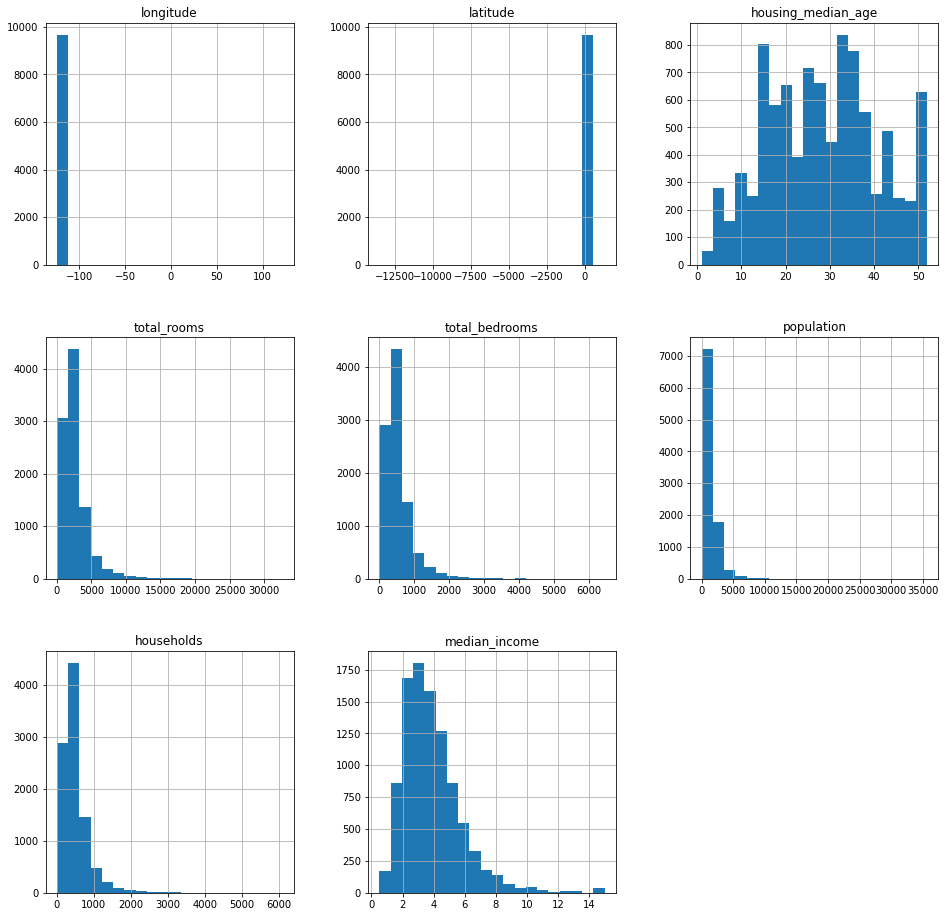

In [31]:
X.hist(figsize=(16,16), bins=20);

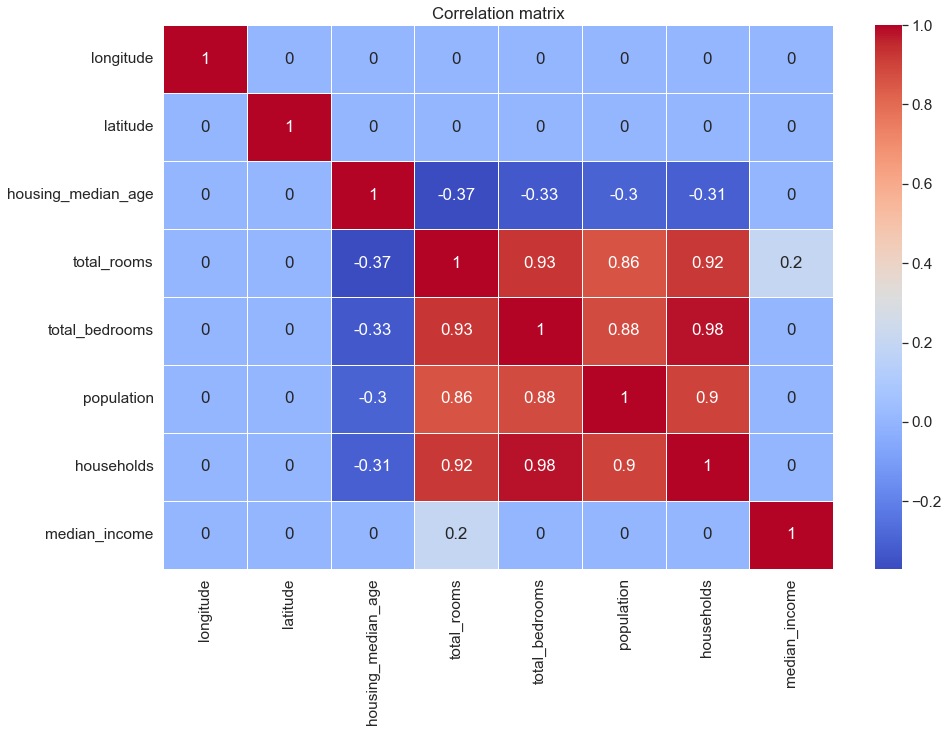

In [32]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
#print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

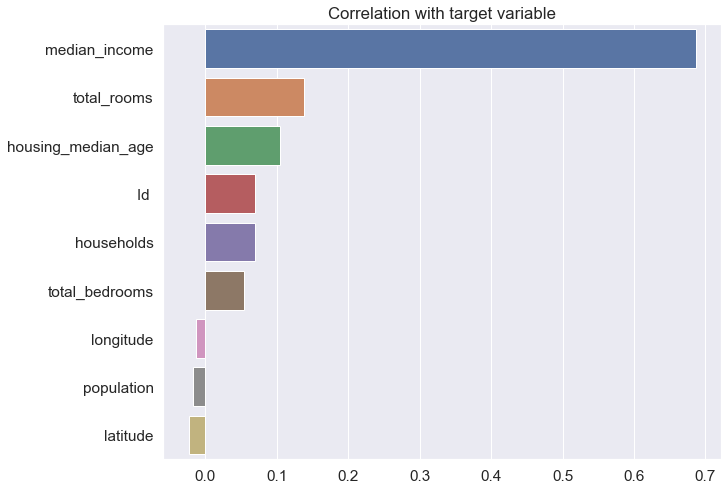

In [33]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Качественные переменные

In [34]:
X['ocean_proximity'].value_counts()

<1H OCEAN     4287
INLAND        3102
NEAR OCEAN    1206
NEAR BAY      1075
-                7
ISLAND           2
Name: ocean_proximity, dtype: int64

In [35]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

# Анализируем и исправляем

C:\Users\Алексей\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


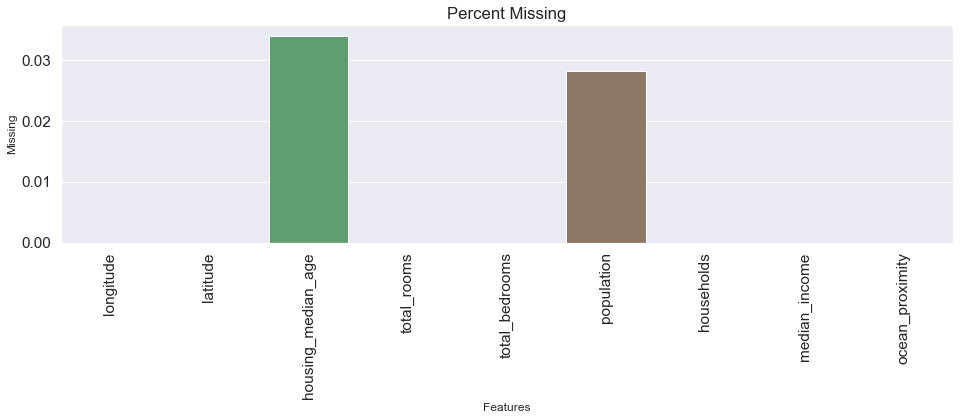

In [36]:
nan_analize(X)

In [55]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [61]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

In [68]:
X.loc[X['longitude'] >= 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
8405,118.360001,33.930000,40.0,1625.0,500.0,2036.0,476.0,2.6298,<1H OCEAN
13051,121.290001,38.610001,17.0,13553.0,2474.0,6544.0,2359.0,3.9727,INLAND
8636,118.410004,33.880001,43.0,2492.0,449.0,1033.0,437.0,7.9614,<1H OCEAN
17085,0.000000,37.470001,33.0,1266.0,415.0,1991.0,334.0,2.9200,NEAR OCEAN
19423,0.000000,37.689999,5.0,9601.0,1639.0,4449.0,1575.0,4.5332,INLAND


In [69]:
# третье
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [74]:
# четвёртое
X.loc[X['longitude'] == 0, 'longitude'] = X['longitude'].median()
X_final.loc[X_final['longitude'] == 0, 'longitude'] = X_final['longitude'].median()

In [79]:
# пятое
median = X['latitude'].median()
X.loc[X['latitude'] < 0, 'latitude'] = median
X_final.loc[X_final['latitude'] < 0, 'latitude'] = median

In [54]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
9797,-121.919998,36.570000,42.0,3944.0,738.0,1374.0,598.0,4.1740,NEAR OCEAN
20618,-121.550003,39.060001,25.0,1332.0,247.0,726.0,226.0,2.2500,INLAND
19139,-122.709999,38.330002,13.0,4011.0,936.0,2064.0,914.0,3.6953,<1H OCEAN
6996,-118.029999,33.950001,34.0,1882.0,428.0,1034.0,375.0,3.6509,<1H OCEAN
840,-122.059998,37.599998,18.0,1726.0,276.0,1186.0,310.0,5.3226,NEAR BAY


In [90]:
 pd.get_dummies(X['ocean_proximity'])

,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Id,,,,,,
9797,0,0,0,0,0,1
20618,0,0,1,0,0,0
19139,0,1,0,0,0,0
6996,0,1,0,0,0,0
840,0,0,0,0,1,0
...,...,...,...,...,...,...
11539,0,1,0,0,0,0
9435,0,0,1,0,0,0
6035,0,0,1,0,0,0


In [91]:
# седьмое
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [92]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,population_per_room,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Id,,,,,,,,,,,,,,,,
9797,-121.919998,36.570000,42.0,3944.0,738.0,1374.0,598.0,4.1740,NEAR OCEAN,0.348377,0,0,0,0,0,1
20618,-121.550003,39.060001,25.0,1332.0,247.0,726.0,226.0,2.2500,INLAND,0.545045,0,0,1,0,0,0
19139,-122.709999,38.330002,13.0,4011.0,936.0,2064.0,914.0,3.6953,<1H OCEAN,0.514585,0,1,0,0,0,0
6996,-118.029999,33.950001,34.0,1882.0,428.0,1034.0,375.0,3.6509,<1H OCEAN,0.549416,0,1,0,0,0,0
840,-122.059998,37.599998,18.0,1726.0,276.0,1186.0,310.0,5.3226,NEAR BAY,0.687138,0,0,0,0,1,0


In [84]:
# шестое
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [58]:
X['population_per_room'].head()

Id 
9797     0.348377
20618    0.545045
19139    0.514585
6996     0.549416
840      0.687138
Name: population_per_room, dtype: float32

In [59]:
X.loc[X['total_bedrooms'] + 1 > X['total_rooms'] ].head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room
Id,,,,,,,,,,,,,,,,
3126,-117.790001,35.209999,4.0,2.0,2.0,6.0,2.0,2.375,INLAND,0,0,1,0,0,0,3.000000
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.536,INLAND,0,0,1,0,0,0,8.736842


In [93]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

# Проверяем модель

In [94]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

X = X[remain_features]
X_final = X_final[remain_features]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [96]:
model = LGBMRegressor(max_depth=15,
                             n_estimators=250,
                             random_state=53)
model.fit(X_train, y_train)

LGBMRegressor(max_depth=15, n_estimators=250, random_state=53)

R2:	0.81846
RMSE:	48861.599
MSE:	2387455848.286


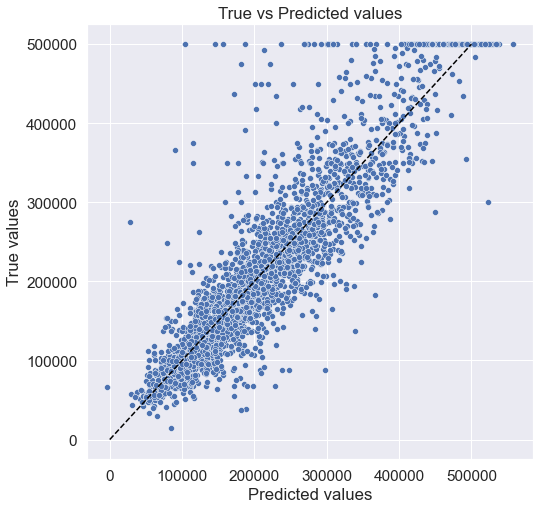

In [97]:
y_pred_test = model.predict(X_test)
#y_test.columns
evaluate_preds(y_test['median_house_value'], y_pred_test)

In [ ]:
# 0.81264
# 0.80827 - убрали ocean_proxmity
# 0.81528 - добавили медиану по возрасту дома в пропуски
# 0.81074 - добавили медиану по популяции
# 0.81292 - поправили 3 longitidu 
# 0.81268 - поправили 0 
# 0.81278 - latitude 
# 0.81849 - добавили новый признак 
# 0.81846 - дамми-переменные на близость к океану

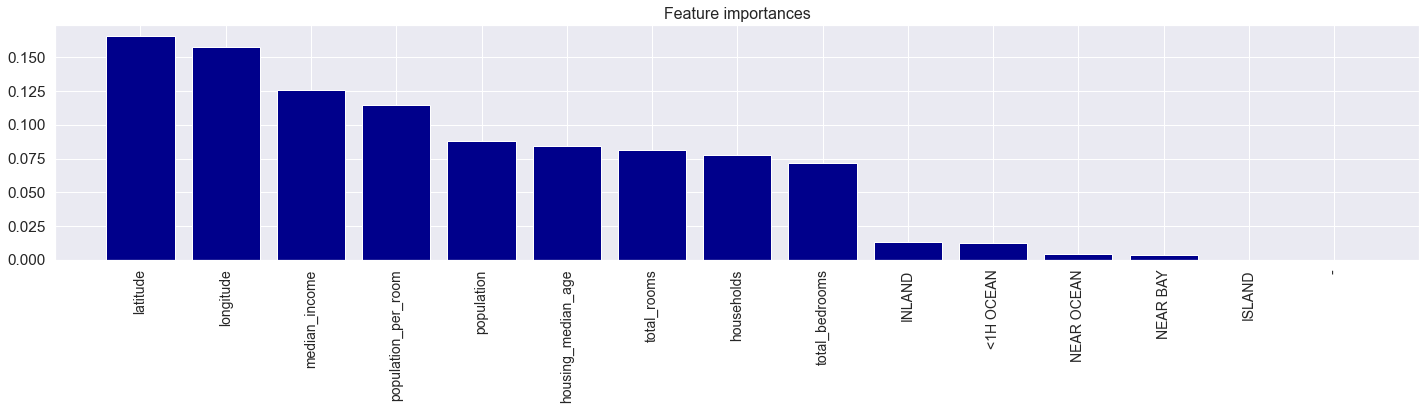

In [98]:
plot_feature_importances(importances = model.feature_importances_, X=X)

## Учим финальную модель

In [100]:
model_lgbm_f = LGBMRegressor(max_depth=15,
                             n_estimators=250,
                             random_state=42)
model_lgbm_f.fit(X, y)

LGBMRegressor(max_depth=15, n_estimators=250, random_state=42)

In [101]:
y_pred_test = model_lgbm_f.predict(X_final)
y_pred_test

array([ 79999.31740445,  70600.88040589, 236917.58752691, ...,
       299998.50748388, 189905.09398589, 201709.4331095 ])

In [102]:
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

In [103]:
y_pred_df

,median_house_value
0,79999.317404
1,70600.880406
2,236917.587527
3,194379.666022
4,332063.636437
...,...
4144,52534.329888
4145,175559.248723
4146,299998.507484
4147,189905.093986


In [104]:
X_final.index

Int64Index([ 3320,  9580, 14220,  3697, 10601,  4276,  5972,   730, 14826,
              325,
            ...
            15007, 14692,  4108, 11673,  4223,  2024, 11203, 17269, 19342,
            16715],
           dtype='int64', name='Id ', length=4149)

In [ ]:
filename = 'yymmdd_Surn_1.csv'
y_pred_df.to_csv(filename, index=None)

## Домашнее задание
Получить большую точность на тестовых данных.
yymmdd_Surn_#.csv
+ноутбук